In [1]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import numpy as np

In [2]:
# Function to parse the flow info log
def parse_flow_info_log(flow_info_file):
    flows = {}
    with open(flow_info_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            flow_id = int(parts[0])
            flows[flow_id] = {
                'start_time': int(parts[6]),
                'end_time': int(parts[6]) + int(parts[7]),  # end_time = start_time + fct
                'links': set(),
                'size': int(parts[5])
            }
    return flows

# Function to parse the link info log
def parse_link_info_log(link_info_file):
    link_flows = defaultdict(set)
    with open(link_info_file, 'r') as file:
        num_links = int(file.readline().strip())
        for _ in range(num_links):
            link_info = list(map(int, file.readline().strip().split(',')))
            flow_ids = list(map(int, file.readline().strip().split(',')[:-1]))
            assert link_info[3] == len(flow_ids)
            link = (link_info[1], link_info[2])
            link_flows[link].update(flow_ids)
    return link_flows

# Optimized function to assign links to flows
def assign_links_to_flows(flows, link_flows):
    for link, flow_ids in link_flows.items():
        for flow_id in flow_ids:
            if flow_id in flows:
                flows[flow_id]['links'].add(link)
    return flows

# Function to update bipartite graph and calculate busy periods
def update_bipartite_graph_and_calculate_busy_periods(flows):
    active_graphs = {}  # Dictionary to hold multiple bipartite graphs with graph_id as key
    busy_periods = []  # List to store busy periods
    events = []

    # Precompute events
    for flow_id, flow in flows.items():
        events.append((flow['start_time'], 'start', flow_id, flow['links']))
        events.append((flow['end_time'], 'end', flow_id, flow['links']))

    events.sort()

    link_to_graph = {}  # Map to quickly find which graph a link belongs to
    graph_id_new = 0  # Unique identifier for each graph
    for time, event, flow_id, links in events:
        cur_time = time 
        if flow_id % 1000 == 0:
            print(f'Processing flow {flow_id}')
        if event == 'start':
            # Find all graphs involved with the new flow's links
            involved_graph_ids = set()
            for link in links:
                if link in link_to_graph:
                    involved_graph_ids.add(link_to_graph[link])

            new_active_links = defaultdict(set)
            new_all_links = set()
            new_flows = set()
            new_all_flows = set()
            
            if involved_graph_ids:
                for gid in involved_graph_ids:
                    graph = active_graphs[gid]
                    new_active_links.update(graph['active_links'])
                    new_all_links.update(graph['all_links'])
                    new_flows.update(graph['active_flows'])
                    new_all_flows.update(graph['all_flows'])
                    if cur_time > graph['start_time']:
                        cur_time = graph['start_time']
                    
                    for link in graph['active_links']:
                        link_to_graph[link] = graph_id_new
                    del active_graphs[gid]
            
            for link in links:
                new_active_links[link].add(flow_id)
                new_all_links.add(link)
                link_to_graph[link] = graph_id_new
            new_flows.add(flow_id)
            new_all_flows.add(flow_id)
            active_graphs[graph_id_new] = {
                'active_links': new_active_links,
                'all_links': new_all_links,
                'active_flows': new_flows,
                'all_flows': new_all_flows,
                'start_time': cur_time
            }
            graph_id_new += 1

        elif event == 'end':
            graph = None
            for link in links:
                if link in link_to_graph:
                    graph_id = link_to_graph[link]
                    graph = active_graphs[graph_id]
                    break

            if graph:
                for link in links:
                    if flow_id in graph['active_links'][link]:
                        graph['active_links'][link].remove(flow_id)
                        if not graph['active_links'][link]:
                            del graph['active_links'][link]
                            del link_to_graph[link]
                    else:
                        assert False, f"Flow {flow_id} not found in link {link} of graph {graph_id}"
                if flow_id in graph['active_flows']:
                    graph['active_flows'].remove(flow_id)
                else:
                    assert False, f"Flow {flow_id} not found in active flows of graph {graph_id}"
                if not graph['active_flows']:  # If no active flows left in the graph
                    if len(graph['all_flows']) > 0:  # If there is more than one flow in the graph
                        busy_periods.append((graph['start_time'], cur_time, list(graph['all_links']), list(graph['all_flows'])))
                    del active_graphs[graph_id]
                    for link in graph['active_links']:
                        del link_to_graph[link]
            else:
                assert False, f"Flow {flow_id} has no active graph"
    return busy_periods

def update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold):
    active_graphs = {}  # Dictionary to hold multiple bipartite graphs with graph_id as key
    busy_periods = []  # List to store busy periods
    busy_periods_len = []
    events = []

    # Precompute events
    flow_to_end_time={}
    for flow_id, flow in flows.items():
        events.append((flow['start_time'], 'start', flow_id, flow['links'],flow['size']))
        events.append((flow['end_time'], 'end', flow_id, flow['links'], flow['size']))
        flow_to_end_time[flow_id]=flow['end_time']

    events.sort()

    link_to_graph = {}  # Map to quickly find which graph a link belongs to
    graph_id_new = 0  # Unique identifier for each graph
    large_flow_to_info = {}
    flow_to_size={}
    
    for time, event, flow_id, links, size in events:
        cur_time = time 
        if flow_id % 1000 == 0:
            print(f'Processing flow {flow_id}')
        if event == 'start':
            flow_to_size[flow_id]=size
            if size > flow_size_threshold:
                large_flow_to_info[flow_id] = (time,links)
            # Find all graphs involved with the new flow's links
            involved_graph_ids = set()
            for link in links:
                if link in link_to_graph:
                    involved_graph_ids.add(link_to_graph[link])

            new_active_links = defaultdict(set)
            new_all_links = set()
            new_flows = set()
            new_all_flows = set()
            
            if involved_graph_ids:
                for gid in involved_graph_ids:
                    graph = active_graphs[gid]
                    new_active_links.update(graph['active_links'])
                    new_all_links.update(graph['all_links'])
                    new_flows.update(graph['active_flows'])
                    new_all_flows.update(graph['all_flows'])
                    if cur_time > graph['start_time']:
                        cur_time = graph['start_time']
                    
                    for link in graph['active_links']:
                        link_to_graph[link] = graph_id_new
                    del active_graphs[gid]
            
            for link in links:
                new_active_links[link].add(flow_id)
                new_all_links.add(link)
                link_to_graph[link] = graph_id_new
            new_flows.add(flow_id)
            new_all_flows.add(flow_id)
            active_graphs[graph_id_new] = {
                'active_links': new_active_links,
                'all_links': new_all_links,
                'active_flows': new_flows,
                'all_flows': new_all_flows,
                'start_time': cur_time
            }
            graph_id_new += 1

        elif event == 'end':
            graph = None                
            for link in links:
                if link in link_to_graph:
                    graph_id = link_to_graph[link]
                    graph = active_graphs[graph_id]
                    break

            if graph:
                flow_to_size.pop(flow_id)
                if flow_id in large_flow_to_info:
                    large_flow_to_info.pop(flow_id)
                
                for link in links:
                    if flow_id in graph['active_links'][link]:
                        graph['active_links'][link].remove(flow_id)
                        if not graph['active_links'][link]:
                            del graph['active_links'][link]
                            del link_to_graph[link]
                    else:
                        assert False, f"Flow {flow_id} not found in link {link} of graph {graph_id}"
                if flow_id in graph['active_flows']:
                    graph['active_flows'].remove(flow_id)
                else:
                    assert False, f"Flow {flow_id} not found in active flows of graph {graph_id}"
                # if not graph['active_flows']:  # If no active flows left in the graph
                n_small_flows=len([flow_id for flow_id in graph['active_flows'] if flow_to_size[flow_id]<=flow_size_threshold])
                n_large_flows=len(graph['active_flows'])-n_small_flows
                if n_small_flows==0:  # If no active flows left in the graph
                    end_time=cur_time
                    # for flow_id in graph['active_flows']:
                    #     if flow_to_end_time[flow_id]>end_time:
                    #         end_time=flow_to_end_time[flow_id]
                    busy_periods.append((graph['start_time'], end_time, list(graph['all_links']), list(graph['all_flows'])))
                    busy_periods_len.append(len(graph['all_flows']))
                    
                    del active_graphs[graph_id]
                    for link in graph['active_links']:
                        del link_to_graph[link]
                        
                    if n_large_flows>0:
                        new_active_links = defaultdict(set)
                        new_all_links = set()
                        new_flows = graph['active_flows']
                        new_all_flows = graph['active_flows']
                        start_time=cur_time
                        for flow_id in graph['active_flows']:
                            for link in large_flow_to_info[flow_id][1]:
                                new_active_links[link].add(flow_id)
                                new_all_links.add(link)
                                link_to_graph[link] = graph_id_new
                            # if large_flow_to_info[flow_id][0]<start_time:
                            #     start_time=large_flow_to_info[flow_id][0]
                        active_graphs[graph_id_new] = {
                            'active_links': new_active_links,
                            'all_links': new_all_links,
                            'active_flows': new_flows,
                            'all_flows': new_all_flows,
                            'start_time': start_time
                        }
                        graph_id_new += 1
            else:
                assert False, f"Flow {flow_id} has no active graph"
    return busy_periods

# Function to save results to a file
def save_results(filename, busy_periods):
    with open(filename, 'w') as file:
        json.dump(busy_periods, file)

# Function to read results from a file
def read_results(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [3]:
# Function to plot the CDF
def plot_cdf(data, xlabel, ylabel, title,ax):
    data_sorted = np.sort(data)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    ax.plot(data_sorted, cdf, marker='.', linestyle='none')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

# Function to plot the relationship between number of flows and number of links
def plot_relationship(x_data, y_data, xlabel, ylabel, title,ax):
    ax.scatter(x_data, y_data, alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

# Function to plot the number of busy periods over time
def plot_busy_periods_over_time(busy_periods,ax):
    events = []

    for start_time, end_time, links, all_flows in busy_periods:
        events.append((start_time, 'start'))
        events.append((end_time, 'end'))

    events.sort()
    busy_count = 0
    times = []
    counts = []

    for time, event in events:
        if event == 'start':
            busy_count += 1
        elif event == 'end':
            busy_count -= 1
        times.append(time)
        counts.append(busy_count)

    ax.plot(times, counts, drawstyle='steps-post')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Busy Periods')
    ax.set_title('Number of Busy Periods Over Time')
    ax.grid(True)

def plot_active_flows_during_longest_period(busy_periods,flows_info,ax):
    # Find the longest busy period
    busiest_period = max(busy_periods, key=lambda x: len(x[3]))  # x[3] contains the flows
    start_time, end_time, _, all_flows = busiest_period

    # Collect start and end times of flows within the longest busy period
    events = []
    print(f'Longest busy period: {len(all_flows)} flows, from  {start_time} to {end_time}')
    for flow_id in all_flows:
        flow = flows_info[flow_id]
        flow_start = flow['start_time']
        flow_end = flow['end_time']
        assert not (flow_start > end_time or flow_end < start_time)
        events.append((flow_start, 'start'))
        events.append((flow_end, 'end'))

    events.sort()

    # Calculate the number of active flows over time
    active_flows = 0
    times = []
    counts = []

    for time, event in events:
        if event == 'start':
            active_flows += 1
        elif event == 'end':
            active_flows -= 1
        times.append(time)
        counts.append(active_flows)

    # Plot the number of active flows over time
    ax.step(times, counts, where='post', label='Active Flows')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Active Flows')
    ax.set_title('Number of Active Flows During the Longest Busy Period')
    ax.grid(True)
    ax.legend()

def plot_active_links_during_longest_period(busy_periods, flows_data,ax):
    # Find the longest busy period
    busiest_period = max(busy_periods, key=lambda x: len(x[3]))  # x[3] contains the flows
    start_time, end_time, _, all_flows = busiest_period

    # Collect start and end times of flows within the longest busy period
    events = []
    for flow_id in all_flows:
        flow = flows_data[flow_id]
        flow_start = flow['start_time']
        flow_end = flow['end_time']
        assert not (flow_start > end_time or flow_end < start_time)
        events.append((flow_start, 'start', flow['links'],flow_id))
        events.append((flow_end, 'end', flow['links'],flow_id))

    events.sort()

    # Calculate the number of active links over time
    active_links = defaultdict(set)
    times = []
    counts = []

    for time, event, links,flow_id in events:
        if event == 'start':
            for link in links:
                active_links[link].add(flow_id)
        elif event == 'end':
            for link in links:
                active_links[link].remove(flow_id)
                if not active_links[link]:
                    del active_links[link]
        times.append(time)
        counts.append(len(active_links))

    # Plot the number of active links over time
    ax.step(times, counts, where='post', label='Active Links')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Active Links')
    ax.set_title('Number of Active Links During the Longest Busy Period')
    ax.grid(True)
    ax.legend()


Found 53180 busy periods
sum of number of flows: 1777451
max number of flows: 301 with index 12602 and links 427
Longest busy period: 301 flows, from  1895756132 to 1898466220


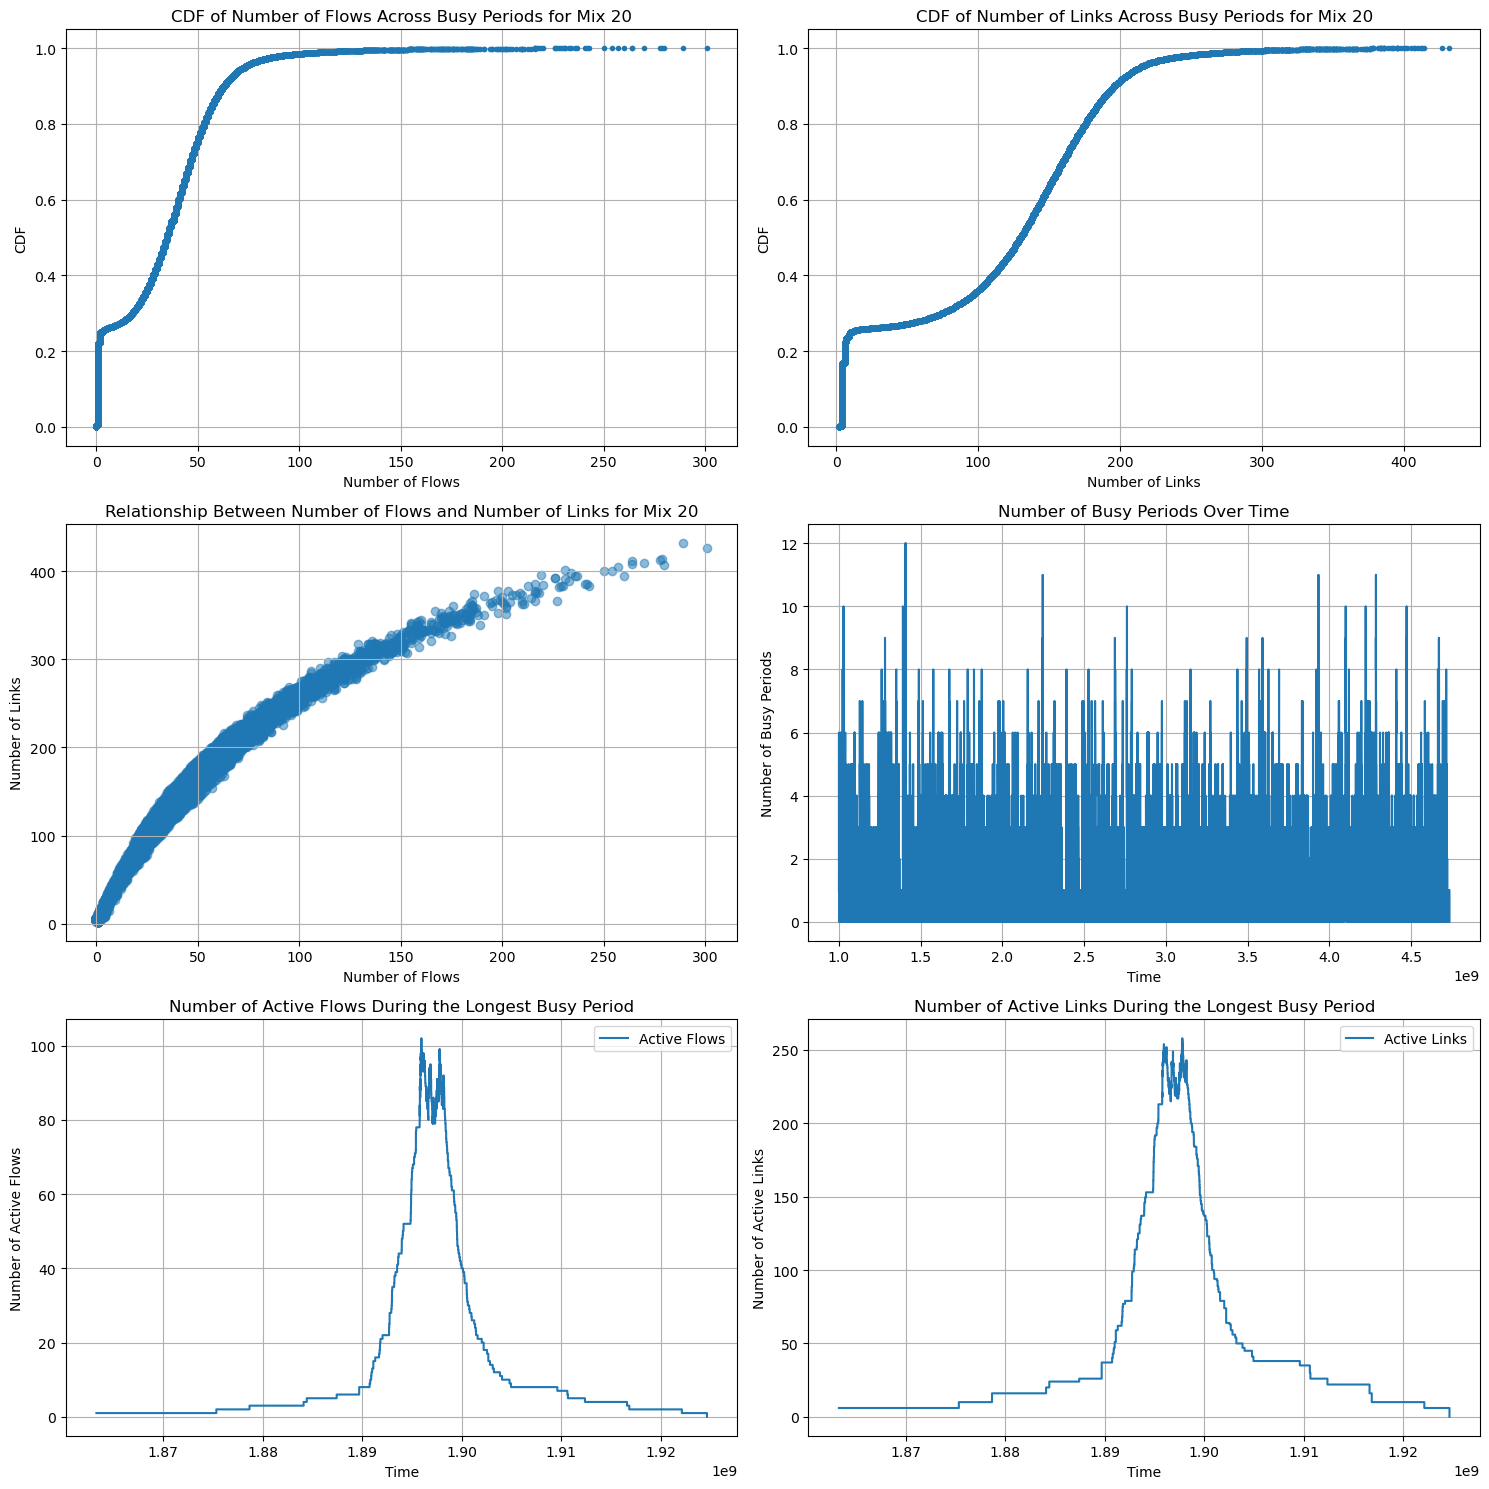

Found 26803 busy periods
sum of number of flows: 286085
max number of flows: 1599 with index 23586 and links 676
Longest busy period: 1599 flows, from  1624277001 to 1629278019


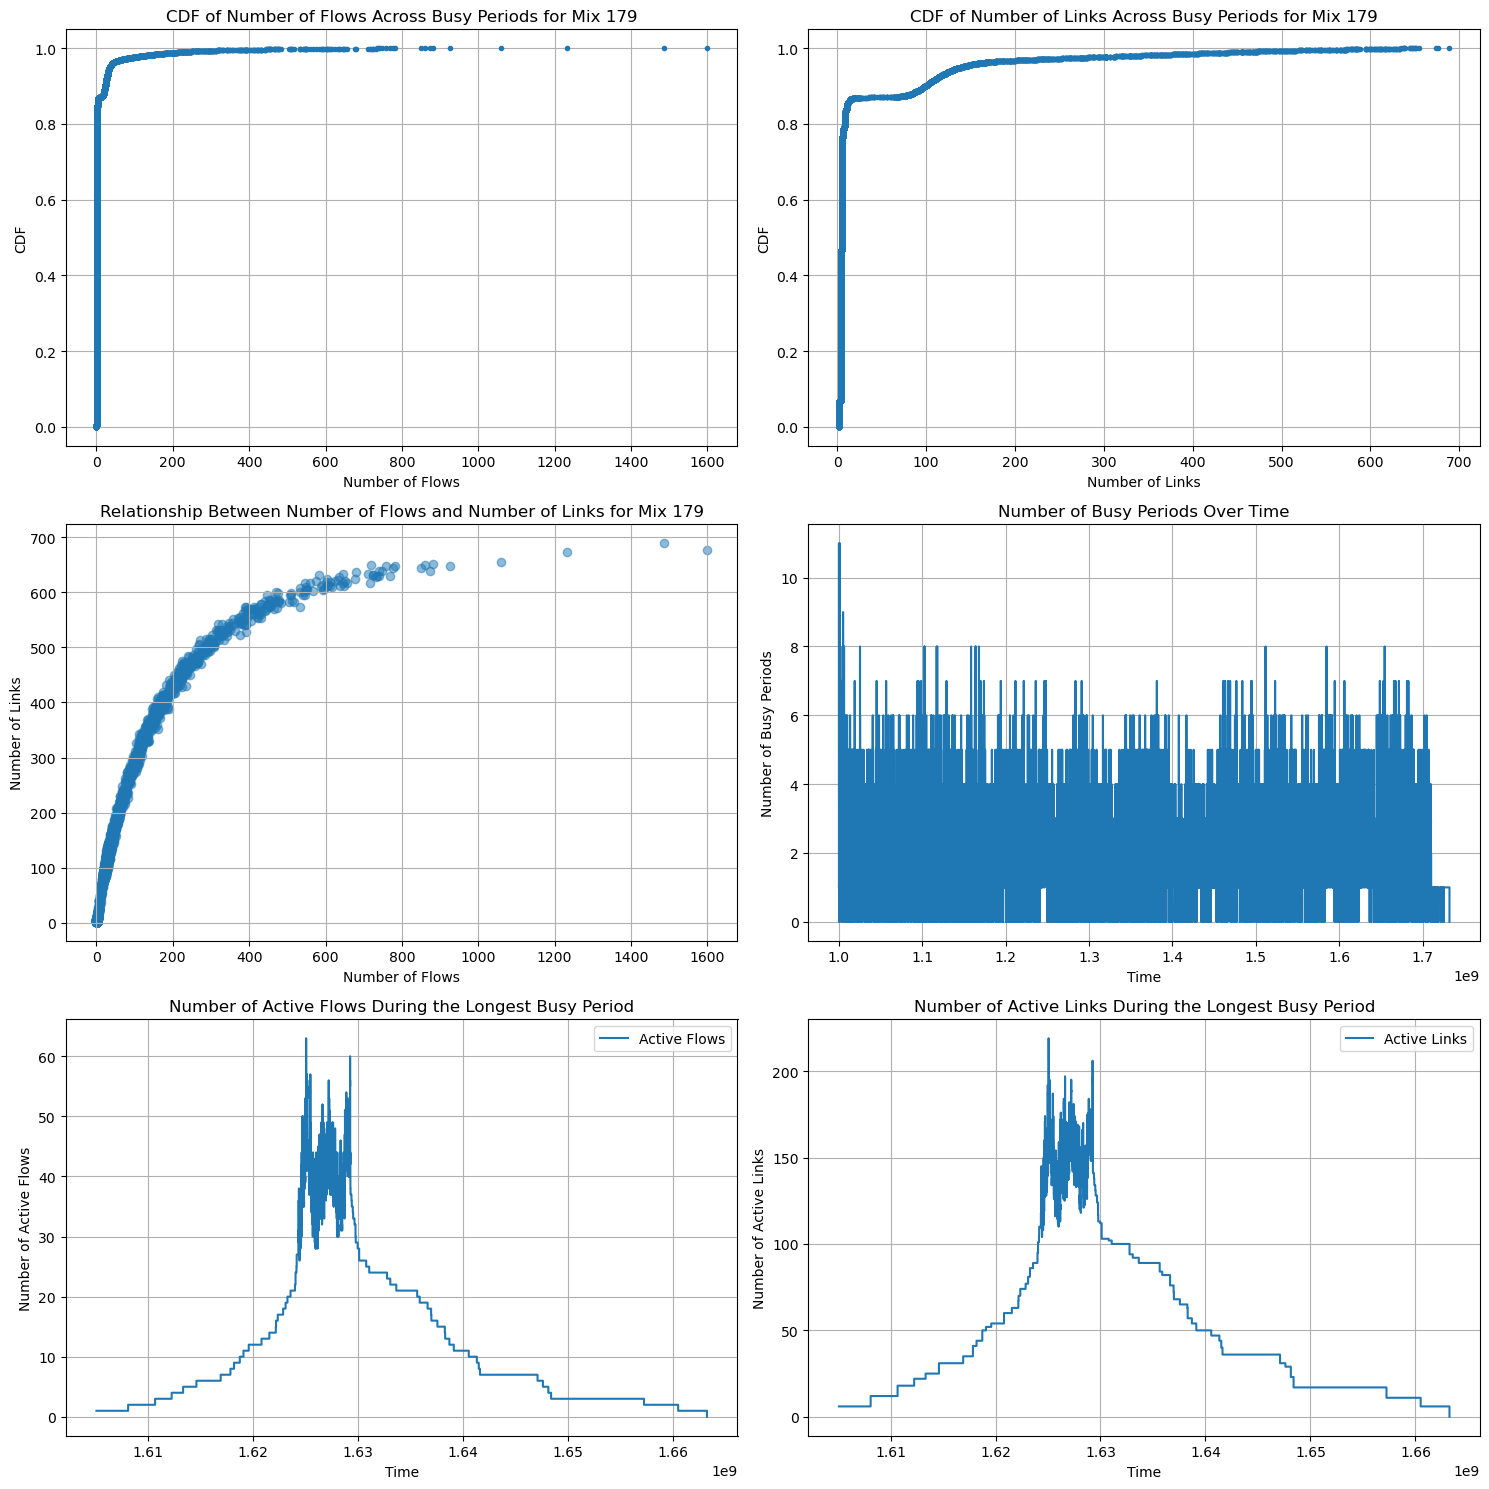

Found 63934 busy periods
sum of number of flows: 219635
max number of flows: 20183 with index 23918 and links 704
Longest busy period: 20183 flows, from  1086256466 to 1136287573


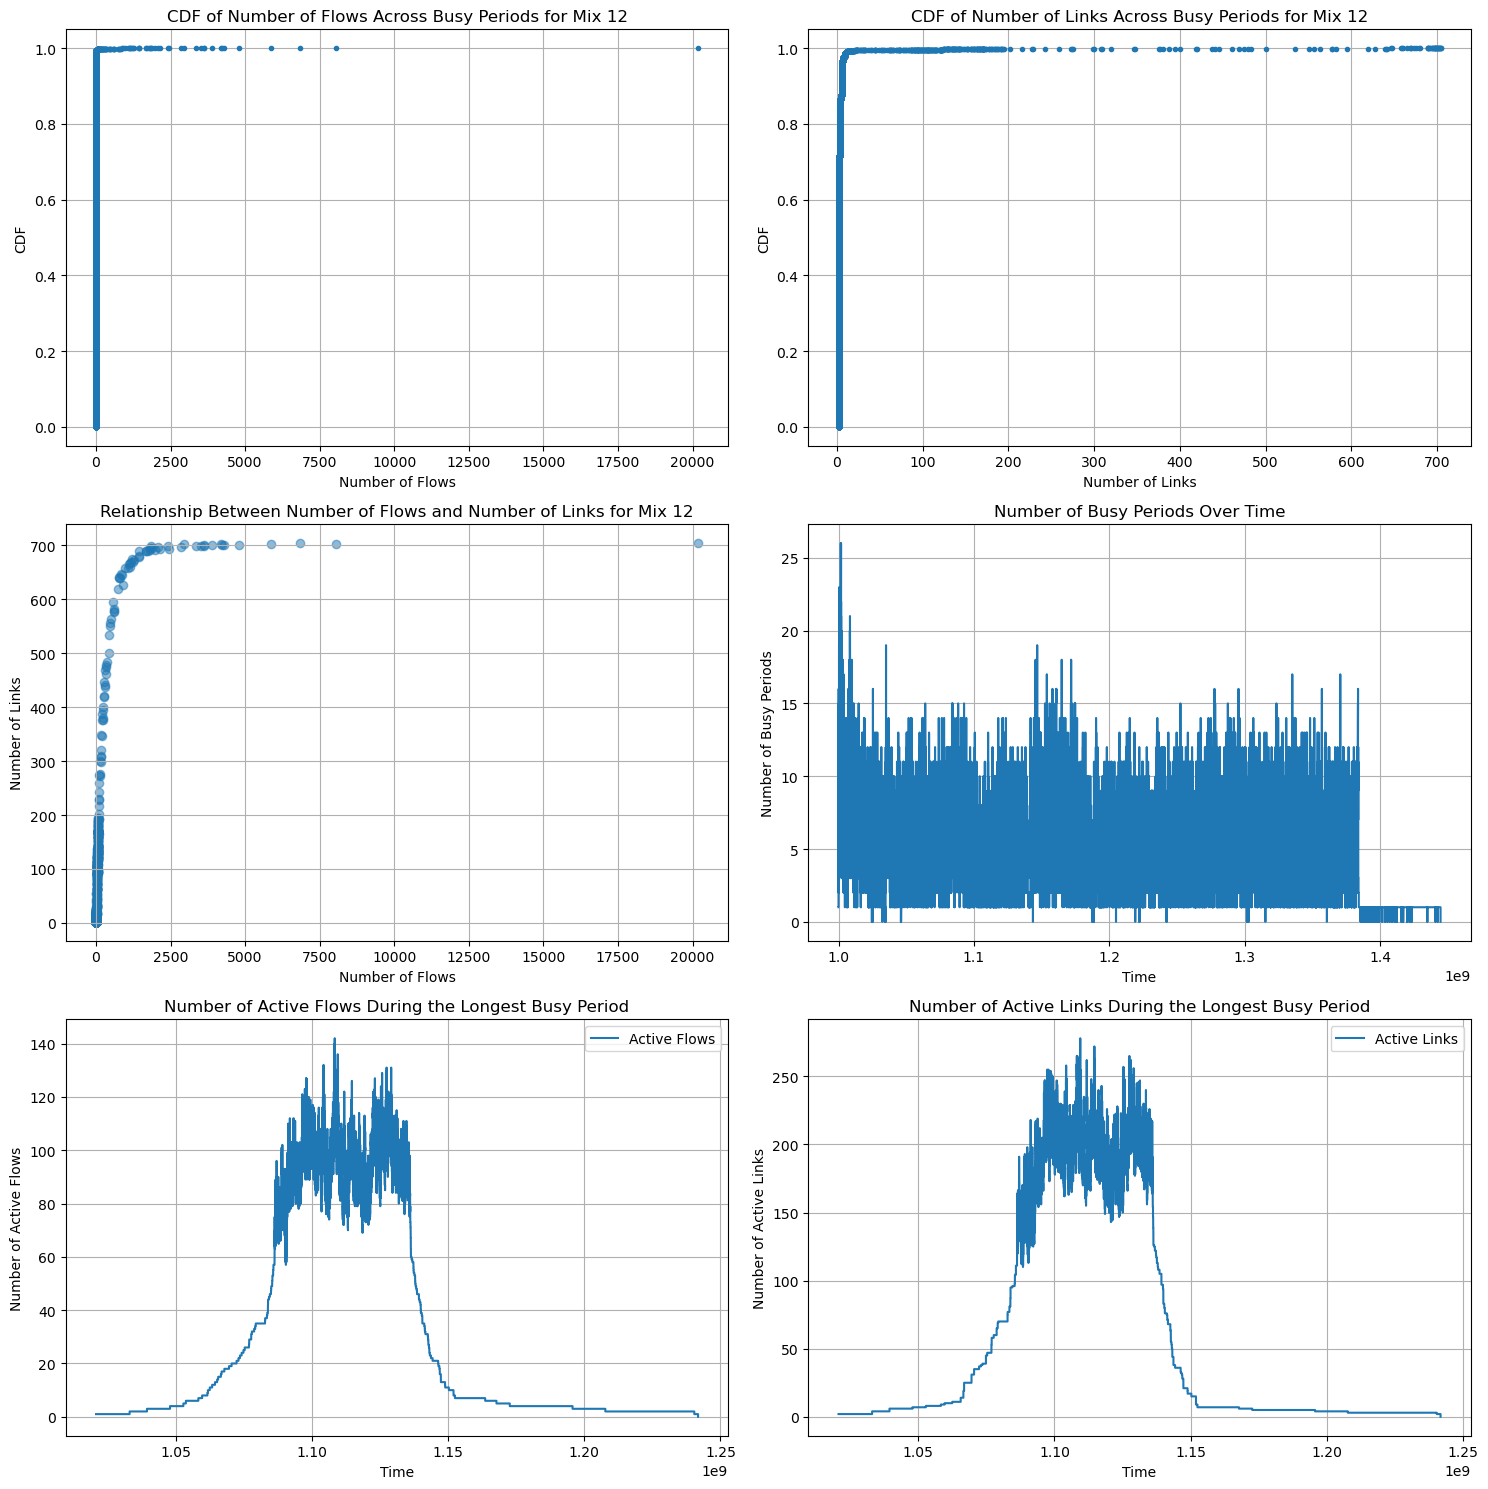

In [10]:
root_dir = '../data_test/'  # Update with the path to your root directory
flow_size_threshold=200000
mix_list = [20, 179, 12]
for mix_id in mix_list:
    flow_info_file = f"{root_dir}{mix_id}/ns3-config/0/fct_topology_flows_dctcp.txt"
    link_info_file = f"{root_dir}{mix_id}/mlsys-test/path_0.txt"
    result_file = f"./res/busy_periods_{mix_id}_t{flow_size_threshold}.json"

    # Parse logs
    if os.path.exists(result_file):
        busy_periods = read_results(result_file)
    else:
        flows = parse_flow_info_log(flow_info_file)
        print(f'Parsed {len(flows)} flows')
        link_flows = parse_link_info_log(link_info_file)
        print(f'Parsed {len(link_flows)} links')
        
        # Assign links to flows
        flows = assign_links_to_flows(flows, link_flows)
        
        # Update bipartite graph and calculate busy periods
        # busy_periods = update_bipartite_graph_and_calculate_busy_periods(flows)
        busy_periods = update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold)
        
        # Save results
        save_results(result_file, busy_periods)
        print(f'Saved results to {result_file}')
    print(f'Found {len(busy_periods)} busy periods')
    # Plot CDF of number of flows across busy periods
    num_flows = [len(period[3]) for period in busy_periods]
    print(f"sum of number of flows: {sum(num_flows)}")
    index_max=num_flows.index(max(num_flows))
    print(f"max number of flows: {max(num_flows)} with index {index_max} and links {len(busy_periods[index_max][2])}")
    
    num_links = [len(period[2]) for period in busy_periods]
    
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    plot_cdf(num_flows, 'Number of Flows', 'CDF', f'CDF of Number of Flows Across Busy Periods for Mix {mix_id}', axs[0, 0])
    plot_cdf(num_links, 'Number of Links', 'CDF', f'CDF of Number of Links Across Busy Periods for Mix {mix_id}', axs[0, 1])
    plot_relationship(num_flows, num_links, 'Number of Flows', 'Number of Links', f'Relationship Between Number of Flows and Number of Links for Mix {mix_id}', axs[1, 0])
    plot_busy_periods_over_time(busy_periods, axs[1, 1])
    
    
    flows = parse_flow_info_log(flow_info_file)
    link_flows = parse_link_info_log(link_info_file)
    flows = assign_links_to_flows(flows, link_flows)
        
    plot_active_flows_during_longest_period(busy_periods, flows, axs[2, 0])
    
    plot_active_links_during_longest_period(busy_periods, flows, axs[2, 1])
    
    plt.tight_layout()
    plt.show()